# Reinforcement Learning: Replacing the Q table with a Neural Network

We will use the Towers of Hanoi puzzle as an example.  Recall that for Assignment 5 you used a Python dictionary to represent the Q function as a table, indexed by a key composed of the state and action.  Here, we simply replace the dictionary with a neural network that receives as input the state and action and outputs one value, Q(state, action).

First, here is one solution to Assignment 5.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

In [2]:
def printState(s):
    lens = [len(p) for p in s]
    for height in range(max(lens),0,-1):
        row = ""
        for p in range(3):
            if lens[p] >= height:
                row += str(s[p][lens[p]-height]) + ' '
            else:
                row += '  '
        print(row)
    print('------')
    print()

In [3]:
printState([[1,2,3],[],[]])

1     
2     
3     
------



In [4]:
def validMoves(state):
    """Given state like [[1,2,3],[],[]]
    return valid moves, like [(1,2),(1,3)]) pairs of source and dest peg"""
    moves = []
    disksOn1,disksOn2,disksOn3 = state
    if disksOn1:
        diskToMove = disksOn1[0]
        if not disksOn2 or disksOn2[0] > diskToMove:
            moves.append([1,2])
        if not disksOn3 or disksOn3[0] > diskToMove:
            moves.append([1,3])
    if disksOn2:
        diskToMove = disksOn2[0]
        if not disksOn1 or disksOn1[0] > diskToMove:
            moves.append([2,1])
        if not disksOn3 or disksOn3[0] > diskToMove:
            moves.append([2,3])
    if disksOn3:
        diskToMove = disksOn3[0]
        if not disksOn1 or disksOn1[0] > diskToMove:
            moves.append([3,1])
        if not disksOn2 or disksOn2[0] > diskToMove:
            moves.append([3,2])
    return moves

def makeMove(state, move):
    from copy import deepcopy
    stateNew = deepcopy(state)
    src,dest = move
    diskMoved = stateNew[src-1].pop(0)
    stateNew[dest-1].insert(0,diskMoved)
    return stateNew

In [5]:
validMoves([[1,2,3], [], []])

[[1, 2], [1, 3]]

In [6]:
printState(makeMove([[1,2,3], [], []], [1, 3]))

2     
3   1 
------



In [7]:
def stateMoveTuple(state, action):
    return (tuple(tuple(disks) for disks in state), tuple(action))

In [8]:
stateMoveTuple([[1,2,3],[],[]], [1,3])

(((1, 2, 3), (), ()), (1, 3))

In [9]:
def epsilonGreedy(Q, state, epsilon, validMovesF):
    moves = validMovesF(state)
    if np.random.uniform() < epsilon: # random move
        move = moves[random.sample(range(len(moves)),1)[0]]
    else:                           # greedy move
        qs = []
        for m in moves:
            key = stateMoveTuple(state, m)
            if key not in Q:
                Q[key] = 0
            qs.append(Q[key])
        move = moves[np.argmax(qs)]
    return move   

In [10]:
def trainQ(nReps, rho, epsilonDecayFactor, validMovesF, makeMoveF):
    outcomes = np.zeros(nReps)             # number steps to goal
    Q = {}                                  # initialize Q dictionary
    epsilon = 1.0                           # initial epsilon value

    for rep in range(nReps):              # iterate over multiple games

        epsilon *= epsilonDecayFactor
        step = 0
        state = [[1,2,3],[],[]]

        # if rep == nReps-1 or debug:
        #     printState(state)

        done = False
        while not done:
            step += 1
            move = epsilonGreedy(Q, state, epsilon, validMovesF)
            key = stateMoveTuple(state, move)
            if key not in Q:
                Q[key] = 0
            stateNew = makeMoveF(state, move)

            # if rep == nReps-1 or debug:
            #     printState(stateNew)

            if len(stateNew[2]) == 3:
                # goal found
                Q[key] = -1
                done = True
                outcomes[rep]=step-1

            elif step > 1:
                #keyOld = tuple([i for peg in stateOld+[moveOld] for i in peg+[0]])
                Q[keyOld] += rho * (-1 + Q[key] - Q[keyOld])

            state = stateNew
            keyOld = key

    return Q, outcomes

In [11]:
Q, outcomes = trainQ(50, 0.5, 0.9, validMoves, makeMove)

In [12]:
outcomes

array([ 162.,   86.,    7.,   20.,   68.,   49.,   26.,   11.,   19.,
         29.,    6.,   60.,   12.,    6.,    6.,    6.,    6.,   23.,
         24.,    6.,    9.,   21.,    7.,   14.,   13.,    8.,    6.,
          6.,    6.,    9.,    7.,   12.,    6.,    6.,    6.,    6.,
          6.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,
          6.,    6.,    6.,    6.,    6.])

In [13]:
len(Q)

76

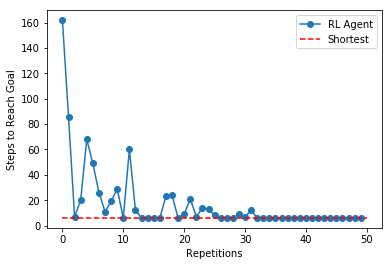

In [14]:
plt.plot(outcomes,'o-', label='RL Agent')
plt.plot([0, len(outcomes)], [6, 6], 'r--', label='Shortest')
plt.xlabel('Repetitions')
plt.ylabel('Steps to Reach Goal')
plt.legend();

In [15]:
def testQ(Q, maxSteps, validMovesF, makeMoveF):
    state = [[1,2,3],[],[]]
    path = [state]
    for step in range(maxSteps):
        moves = validMovesF(state)
        
        qs = []
        for m in moves:
            key = stateMoveTuple(state, m)
            qs.append(Q[key])
        move = moves[np.argmax(qs)]
        state = makeMoveF(state, move)
        path.append(state)

        if len(state[2]) == 3:
            # goal found
            return path

    return None

In [16]:
path = testQ(Q, 100, validMoves, makeMove)

In [17]:
for s in path:
    printState(s)

1     
2     
3     
------

2     
3   1 
------

3 2 1 
------

  1   
3 2   
------

  1   
  2 3 
------

1 2 3 
------

    2 
1   3 
------

    1 
    2 
    3 
------



## Q Network

In [18]:
import neuralnetworks as nn

We must come up with a numerical representation of the state as a vector.  How about $(d_1, d_2, d_3)$, where $d_i$ is the peg that disk $i$ is on.  Let's say $d_1$ is the smallest disk and $d_3$ is the largest disk.  So the starting state is $(1, 1, 1)$ and the goal state is $(3, 3, 3)$.

To represent an action, we can still use two integers, for the source page and the destination peg.  So, action $(1, 3)$ transforms state $(1, 1, 1)$ to state $(3, 1, 1)$.

So, our Q network takes five numerical inputs, three for the state and two for the action.

We need to change the above functions to handle the new state representation, or just write a function that converts our original representation (list of three lists) to our new one (list of three integers).

In [19]:
def newStateRep(state):
    newrep = [0, 0, 0]
    for pegi, peglist in enumerate(state):
        for disk in peglist:
            newrep[disk-1] = pegi+1
    return newrep    

In [20]:
newStateRep([[1, 2, 3], [], []])

[1, 1, 1]

In [21]:
newStateRep([[3], [2], [1]])

[3, 2, 1]

In [22]:
newStateRep([[], [2, 3], [1]])

[3, 2, 2]

In [59]:
def epsilonGreedy(Qnet, state, epsilon, validMovesF):
    moves = validMovesF(state)
    if np.random.uniform() < epsilon: # random move
        move = moves[random.sample(range(len(moves)),1)[0]]
        if Qnet.Xmeans is None:
            Q = 0
        else:
            Q = Qnet.use(np.array([newStateRep(state) + move]))
    else:                           # greedy move
        qs = []
        for m in moves:
            qs.append(Qnet.use(np.array([newStateRep(state) + m])))
        move = moves[np.argmax(qs)]
        Q = np.max(qs)
    return move, Q

Basic algorithm for collecting samples of $(s, a, r', Q')$.

- Initialize $s$.
- Pick $a$
- Repeat until done:
  - $s'$ = makeMove($s$, $a$)
  - $r'$ = -1
  - $a'$ = epsilonGreedy move($s'$)
  - $Q'$ = Qnet($s'$, $a'$)
  - Add to samples collection $(s, a, r', Q')$
  - $s$ = $s'$
  - $a$ = $a'$

In [199]:
def trainQnet(nReps, hiddenLayers, nIterations, epsilonDecayFactor, validMovesF, makeMoveF):
    outcomes = np.zeros(nReps)
    Qnet = nn.NeuralNetwork(5, hiddenLayers, 1)
    Qnet.standardizeT = lambda x: x
    Qnet.unstandardizeT = lambda x: x
    # Qnet.Tmeans = 0
    epsilon = 1.0

    samples = []  # collect all samples for this repetition, then update the Q network at end of repetition.
    for rep in range(nReps):
        if rep > 0:
            epsilon *= epsilonDecayFactor
        step = 0
        done = False

        samples = []
        state = [[1,2,3],[],[]]
        move, _ = epsilonGreedy(Qnet, state, epsilon, validMovesF)
 
        while not done:
            step += 1
            
           # Make this move to get to nextState
            stateNext = makeMoveF(state, move)
            r = -1
            # Choose move from nextState
            moveNext, Qnext = epsilonGreedy(Qnet, stateNext, epsilon, validMovesF)
 
            if len(stateNext[2]) == 3:
                # goal found
                Qnext = 0
                done = True
                outcomes[rep] = step-1
                print('({:d} {:.3f} {:d})'.format(rep,epsilon, int(outcomes[rep])), end=' ')
               
            samples.append([*newStateRep(state), *move, r, Qnext])

            state = deepcopy(stateNext)
            move = deepcopy(moveNext)
            
        samples = np.array(samples)
        X = samples[:,:5]
        T = samples[:,5:6] + samples[:,6:7]
        Qnet.train(X, T, nIterations, verbose=False)
        # print('for (1,2,3, 2,3)', Qnet.use(np.array([[1,2,3, 2,3]])))
    return Qnet, outcomes, samples

In [215]:
Qnet, outcomes, samples = trainQnet(400, [20, 20], 5, 0.992, validMoves, makeMove)

(0 1.000 82) (1 0.992 48) (2 0.984 32) (3 0.976 88) (4 0.968 130) (5 0.961 119) (6 0.953 49) (7 0.945 229) (8 0.938 52) (9 0.930 175) (10 0.923 46) (11 0.915 89) (12 0.908 98) (13 0.901 14) (14 0.894 260) (15 0.886 32) (16 0.879 13) (17 0.872 106) (18 0.865 127) (19 0.858 200) (20 0.852 32) (21 0.845 41) (22 0.838 17) (23 0.831 455) (24 0.825 183) (25 0.818 33) (26 0.812 342) (27 0.805 25) (28 0.799 25) (29 0.792 50) (30 0.786 32) (31 0.780 61) (32 0.773 33) (33 0.767 39) (34 0.761 98) (35 0.755 20) (36 0.749 111) (37 0.743 46) (38 0.737 124) (39 0.731 116) (40 0.725 61) (41 0.719 24) (42 0.714 40) (43 0.708 362) (44 0.702 183) (45 0.697 73) (46 0.691 60) (47 0.686 15) (48 0.680 112) (49 0.675 26) (50 0.669 23) (51 0.664 66) (52 0.659 38) (53 0.653 63) (54 0.648 63) (55 0.643 190) (56 0.638 158) (57 0.633 60) (58 0.628 250) (59 0.623 12) (60 0.618 46) (61 0.613 41) (62 0.608 100) (63 0.603 86) (64 0.598 42) (65 0.593 85) (66 0.589 22) (67 0.584 248) (68 0.579 41) (69 0.575 73) (70 0.57

In [216]:
outcomes

array([   82.,    48.,    32.,    88.,   130.,   119.,    49.,   229.,
          52.,   175.,    46.,    89.,    98.,    14.,   260.,    32.,
          13.,   106.,   127.,   200.,    32.,    41.,    17.,   455.,
         183.,    33.,   342.,    25.,    25.,    50.,    32.,    61.,
          33.,    39.,    98.,    20.,   111.,    46.,   124.,   116.,
          61.,    24.,    40.,   362.,   183.,    73.,    60.,    15.,
         112.,    26.,    23.,    66.,    38.,    63.,    63.,   190.,
         158.,    60.,   250.,    12.,    46.,    41.,   100.,    86.,
          42.,    85.,    22.,   248.,    41.,    73.,    13.,   182.,
         243.,   329.,   129.,    41.,   159.,    22.,    87.,    11.,
          11.,    74.,    27.,    12.,    22.,    52.,    15.,    14.,
          19.,    95.,     9.,    72.,    18.,   200.,    13.,    44.,
          84.,    16.,   139.,     8.,    15.,    16.,    15.,    30.,
          90.,    50.,    12.,    11.,    10.,    28.,    33.,    36.,
      

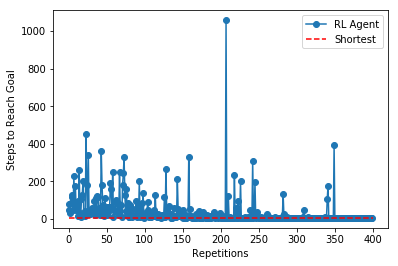

In [217]:
plt.plot(outcomes,'o-', label='RL Agent')
plt.plot([0, len(outcomes)], [6, 6], 'r--', label='Shortest')
plt.xlabel('Repetitions')
plt.ylabel('Steps to Reach Goal')
plt.legend();

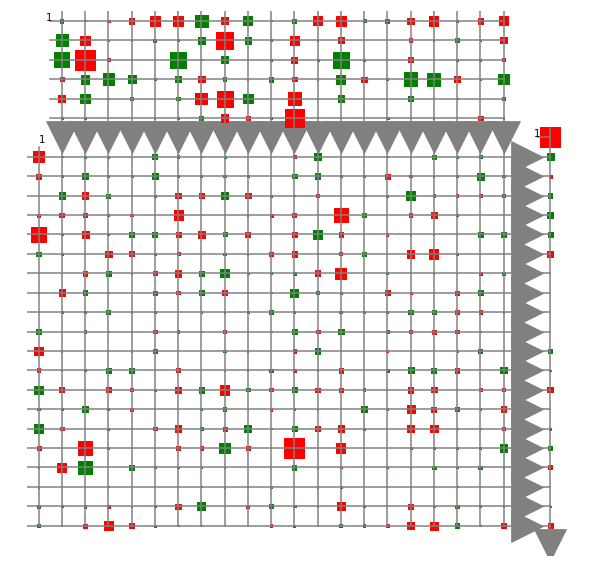

In [218]:
plt.figure(figsize=(10,10))
Qnet.draw()

In [220]:
%precision 3

'%.3f'

In [221]:
for sa in [ [1,1,1, 1,3], [3,1,1, 1,2], [3,2,1, 3,2], [2,2,1, 1,3], [2,2,3, 2,1], [1,2,3, 2,3], [1,3,3, 1,3]]:
    print(sa, Qnet.use(np.array([sa])))

[1, 1, 1, 1, 3] [[-7.001]]
[3, 1, 1, 1, 2] [[-5.998]]
[3, 2, 1, 3, 2] [[-4.998]]
[2, 2, 1, 1, 3] [[-4.002]]
[2, 2, 3, 2, 1] [[-2.999]]
[1, 2, 3, 2, 3] [[-2.]]
[1, 3, 3, 1, 3] [[-1.]]
